In [1]:
import torch
torch.__version__

'1.5.0+cu101'

In [2]:
# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [3]:
!pip install transformers

     |████████████████████████████████| 675kB 2.8MB/s 
     |████████████████████████████████| 890kB 13.7MB/s 
     |████████████████████████████████| 1.1MB 12.9MB/s 
     |████████████████████████████████| 3.8MB 24.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=f541822d0412197ca5b1ca6af64486bf5016ecdba783ee2f4d06a143a6b85903
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [4]:
from transformers import BertTokenizer, BertForQuestionAnswering
from transformers import __version__ as ppt__version__
ppt__version__

'2.11.0'

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

question, text = "Who was Jim Henson?", "Jim Henson was a nice puppet"
encoding = tokenizer.encode_plus(question, text)
input_ids, token_type_ids = encoding["input_ids"], encoding["token_type_ids"]
start_scores, end_scores = model(torch.tensor([input_ids]), token_type_ids=torch.tensor([token_type_ids]))

all_tokens = tokenizer.convert_ids_to_tokens(input_ids)
answer = ' '.join(all_tokens[torch.argmax(start_scores) : torch.argmax(end_scores)+1])

#assert answer == "a nice puppet"
answer

'a nice puppet'

In [6]:
all_tokens[torch.argmax(start_scores) : torch.argmax(end_scores)+1]

['a', 'nice', 'puppet']

In [8]:
### FROM: https://mccormickml.com/2020/03/10/question-answering-with-a-fine-tuned-BERT/

# BERT only needs the token IDs, but for the purpose of inspecting the 
# tokenizer's behavior, let's also get the token strings and display them.
tokens = tokenizer.convert_ids_to_tokens(input_ids)

# For each token and its id...
for token, id in zip(tokens, input_ids):
    
    # If this is the [SEP] token, add some space around it to make it stand out.
    if id == tokenizer.sep_token_id:
        print('')
    
    # Print the token string and its ID in two columns.
    print('{:<12} {:>6,}'.format(token, id))

    if id == tokenizer.sep_token_id:
        print('')

[CLS]           101
who           2,040
was           2,001
jim           3,958
henson       27,227
?             1,029

[SEP]           102

jim           3,958
henson       27,227
was           2,001
a             1,037
nice          3,835
puppet       13,997

[SEP]           102



In [10]:
### Note: In the transformers library, huggingface likes to call these token_type_ids, but I’m going with segment_ids since this seems clearer, and is consistent with the BERT paper.

# Search the input_ids for the first instance of the `[SEP]` token.
sep_index = input_ids.index(tokenizer.sep_token_id)

# The number of segment A tokens includes the [SEP] token istelf.
num_seg_a = sep_index + 1

# The remainder are segment B.
num_seg_b = len(input_ids) - num_seg_a

# Construct the list of 0s and 1s.
segment_ids = [0]*num_seg_a + [1]*num_seg_b

# There should be a segment_id for every input token.
assert len(segment_ids) == len(input_ids)

In [11]:
# Run our example through the model.
start_scores, end_scores = model(torch.tensor([input_ids]), # The tokens representing our input text.
                                 token_type_ids=torch.tensor([segment_ids])) # The segment IDs to differentiate question from answer_text


In [12]:
# Find the tokens with the highest `start` and `end` scores.
answer_start = torch.argmax(start_scores)
answer_end = torch.argmax(end_scores)

# Combine the tokens in the answer and print it out.
answer = ' '.join(tokens[answer_start:answer_end+1])

print('Answer: "' + answer + '"')

Answer: "a nice puppet"


In [13]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
#sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (16,8)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [14]:
# Pull the scores out of PyTorch Tensors and convert them to 1D numpy arrays.
s_scores = start_scores.detach().numpy().flatten()
e_scores = end_scores.detach().numpy().flatten()

# We'll use the tokens as the x-axis labels. In order to do that, they all need
# to be unique, so we'll add the token index to the end of each one.
token_labels = []
for (i, token) in enumerate(tokens):
    token_labels.append('{:} - {:>2}'.format(token, i))

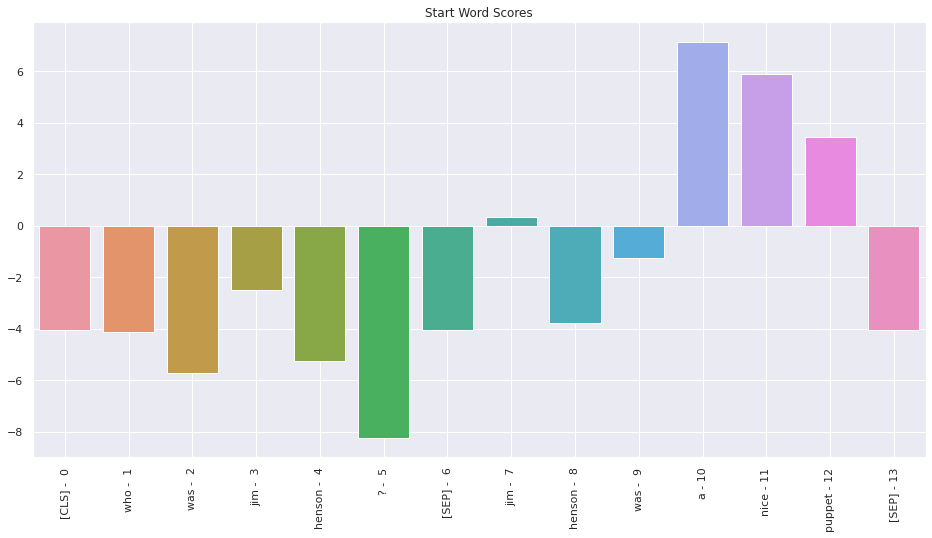

In [15]:
# Create a barplot showing the start word score for all of the tokens.
ax = sns.barplot(x=token_labels, y=s_scores, ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('Start Word Scores')

plt.show()

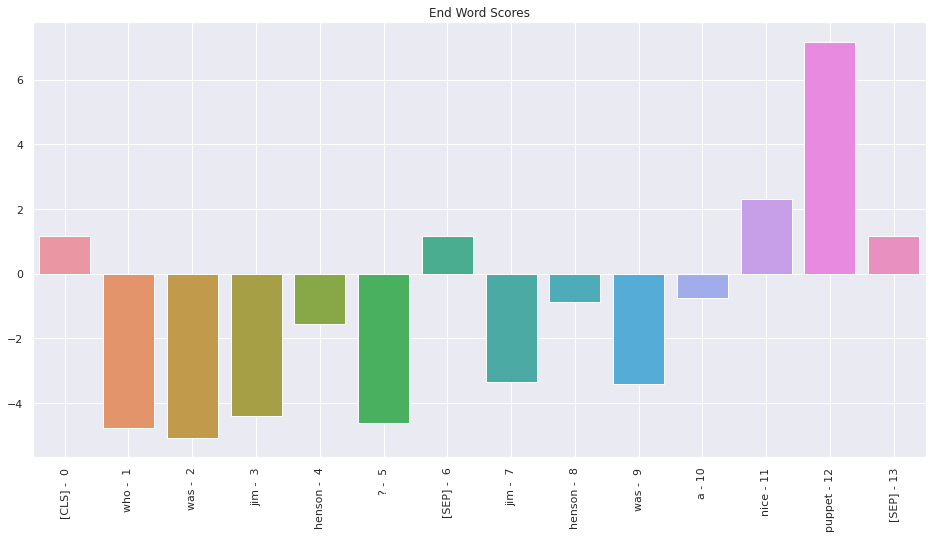

In [16]:
# Create a barplot showing the end word score for all of the tokens.
ax = sns.barplot(x=token_labels, y=e_scores, ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('End Word Scores')

plt.show()

In [17]:
import time
import timeit

#import torch
from torch import nn

from transformers import AutoTokenizer, RobertaTokenizer
from transformers.file_utils import add_start_docstrings, add_start_docstrings_to_callable
from transformers.modeling_roberta import RobertaModel, RobertaForQuestionAnswering
from transformers.modeling_bert import BertEmbeddings, BertEncoder, BertPooler, BERT_INPUTS_DOCSTRING

In [26]:
### FROM: https://huggingface.co/transformers/model_doc/roberta.html#robertaforquestionanswering

# The checkpoint roberta-large is not fine-tuned for question answering. Please see the
# examples/question-answering/run_squad.py example to see how to fine-tune a model to a question answering task.

from transformers import RobertaTokenizer, RobertaForQuestionAnswering
import torch

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForQuestionAnswering.from_pretrained('roberta-base')

question, text = "Who was Jim Henson?", "Jim Henson was a nice puppet"
input_ids = tokenizer.encode(question, text)
start_scores, end_scores = model(torch.tensor([input_ids]))

all_tokens = tokenizer.convert_ids_to_tokens(input_ids)
answer = ' '.join(all_tokens[torch.argmax(start_scores) : torch.argmax(end_scores)+1])

answer

'<s>'

In [24]:
all_tokens

['<s>',
 'ĠWho',
 'Ġwas',
 'ĠJim',
 'ĠH',
 'enson',
 '?',
 '</s>',
 '</s>',
 'ĠJim',
 'ĠH',
 'enson',
 'Ġwas',
 'Ġa',
 'Ġnice',
 'Ġpuppet',
 '</s>']